# CryptoPunks Exploratory Case Study

## Introduction

An NFT is a Non Fungible Token, unique tokens that can be traded and exchanged on the Ethereum blockchain.

CryptoPunks is a collection of 10,000 unique collectible characters, each is a 24x24 pixel, 8-bit-style unique avatar, with proof of ownership stored on the Ethereum blockchain. Their creation began as an experiment, conducted by software developers Matt Hall and John Watkinson in 2017. The Cryptopunks were the inspiration for the ERC-721 standard that powers most digital art and collectibles today. NOTE: Cryptopunks are NOT strictly ERC-20 or ERC-721 tokens (closer to a "custom" ERC-20).

CryptoPunks is the very first NFT series to catch popular interest and one of the most actively traded today. As of April 2022, the market capitalization of all 10,000 CryptoPunks is estimated at around 1,543,250.40 ETH, or over $5B USD (Source: https://nftvaluations.com/cryptopunks).

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import time
from datetime import datetime

import os
import requests
import json
from dotenv import load_dotenv

import plotly.express as px
import matplotlib.pyplot as plt
import hvplot
import seaborn as sns
%matplotlib inline
import PIL
from PIL import Image
import glob
import cv2 as cv
from IPython import display


from pathlib import Path
from tqdm import tqdm
from etherscan import get_punk_balance

## Part 1: Data Collection
### Loading Up and Cleaning the Data

In [37]:
# Data for the most up to date transaction information and the full history of calls to the CryptoPunks contract by date. (Sourced from Etherscan.io)

transactions_df = pd.read_csv('data/transactions.csv', index_col = 'DateTime', parse_dates = True, infer_datetime_format = True, low_memory=False)
transactions_df = transactions_df[['Txhash', 'Blockno', 'From','To', 'Value_IN(ETH)', 'TxnFee(ETH)', 'TxnFee(USD)', 'Historical $Price/Eth', 'Method']]
columns = ['txn_hash', 'block', 'from', 'to', 'value_eth', 'txn_fee_eth', 'txn_fee_usd', 'price', 'contract_call']
transactions_df.columns = columns

# Data for transaction history with Cryptopunk attributes. (Sourced from Kaggle) 

tx_attributes_df = pd.read_json("data/txn_history-2021-10-07.jsonl", lines=True)
tx_attributes_df['date'] = pd.to_datetime(tx_attributes_df.date)
tx_attributes_df = tx_attributes_df[["txn_type", "from", "to", "date", "eth", "punk_id", "type", "accessories"]]
tx_attributes_df = tx_attributes_df.explode("type")
tx_attributes_df['num_attributes'] = tx_attributes_df.accessories.apply(lambda x: len(x))


# Data for Artwork Characteristics
punks = pd.read_csv('data/attributes.csv', index_col = 'id')

# Adding image urls (Sourced from Larva Labs. Images for all CryptoPunks can also be found in this notebook's repository [./data/imgs]
url_base = 'https://www.larvalabs.com/cryptopunks/details/'
urls = []
for i in range(10000):
    url = url_base + str(i)
    urls.append(url)
punks['image_url'] = urls

# Building transaction data with punk IDs
punks_transfers = pd.DataFrame(tx_attributes_df[tx_attributes_df.txn_type == 'Transfer'])[['date', 'punk_id']].set_index(['punk_id', 'date'])

# Building sale data with punk IDs
punks_sales = pd.DataFrame(tx_attributes_df[tx_attributes_df.txn_type == 'Sold'])[['date', 'punk_id', 'eth', 'from', 'to']].set_index(['punk_id', 'date'])

### Previewing the Data

In [3]:
'''

Transactions DataFrame with the most up to date list of contract calls.

--------------------------------------------------------------------------------------------------
Columns:
-DateTime [Index]: Time at which the transaction was processed [in UTC] => DateTime
-txn_hash: Transaction hash. Can be used to identify specific transactions on a block explorer. => String
-block: Block number where the transaction was recorded. => Integer
-from: Address for the sender of the transaction. => String
-to: Address that received the transaction [CryptoPunks contract]. => String
-value_eth: Value transferred into the contract. => Float
-txn_fee_eth: Gas fee in Ether. => Float
-txn_fee_usd: Gas fee converted to USD (based on price of Ether at the time of the transaction). => Float
-price: Price of Ether in USD at the time of the call. => Float
-contract_call: Type of function that was called (from the contract) for each transaction. => String
--------------------------------------------------------------------------------------------------

'''
transactions_df.tail()

,txn_hash,block,from,to,value_eth,txn_fee_eth,txn_fee_usd,price,contract_call
DateTime,,,,,,,,,
2022-04-09 12:49:46,0x12b731b6c657b3db035493f4a51f7b777488d22bfd33...,14551591,0xe83c750b2708320bb134796c555b80df39a3d97b,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,0.0,0.001706,5.488097,NaN,Offer Punk For Sale
2022-04-09 12:50:35,0x61d36019e596db7820f8d116a4ebd5d676068961d8d3...,14551595,0xe83c750b2708320bb134796c555b80df39a3d97b,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,0.0,0.001706,5.488097,NaN,Offer Punk For Sale
2022-04-09 12:50:35,0xf3736cbcd73b72086fdac45c3b5a2e9ef0c895bad331...,14551595,0xe83c750b2708320bb134796c555b80df39a3d97b,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,0.0,0.001706,5.488097,NaN,Offer Punk For Sale
2022-04-09 14:38:00,0x2f70728819df0616a95cec87838c1aada4a4f6bc505f...,14552090,0x0a9cf96cbe9ce142723caa5c2b6a54bf22a1ebc5,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,0.0,0.001913,6.154825,NaN,Transfer Punk
2022-04-09 15:18:34,0x81c06cd81857bdc12d22fd43f127c4f9b3533b6f57eb...,14552276,0x8bebdb7f971d126bed0084c4cc651be40bee0519,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,0.0,0.003823,12.299534,NaN,Offer Punk For Sale


In [92]:
'''

Transaction history with information for the specific Punk that was involved.

--------------------------------------------------------------------------------------------------
Columns:
-txn_type: Type of function that was called (from the contract) for each transaction. => String
-date: Date for each transaction (only up to the day). => DateTime
-eth: Value of the transaction. => Float
-punk_id: Unique ID for each CryptoPunk. => Integer
-type: Type of CryptoPunk (Female, Male, Alien, Ape). => String
-accessories: List of accessories belonging to the specific Punk. => List of Strings
-num_attributes: How many attributes does the specific CryptoPunk have. => Integer
--------------------------------------------------------------------------------------------------

'''
tx_attributes_df.head()

,txn_type,from,to,date,eth,punk_id,type,accessories,num_attributes
0,Bid Withdrawn,0xe73a1d,,2021-09-04,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]",3
1,Bid,0xe73a1d,,2021-09-01,321.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]",3
2,Bid Withdrawn,0x2e5e22,,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]",3
3,Bid,0x2e5e22,,2021-09-01,320.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]",3
4,Bid Withdrawn,0x2e5e22,,2021-09-01,263.0,0,Female,"[Green Eye Shadow, Earring, Blonde Bob]",3


In [5]:
'''

Artwork Characteristics DataFrame

--------------------------------------------------------------------------------------------------
Columns:
-id [Index]: Unique identifier for each CryptoPunk
-type: Species of each CryptoPunk. Possible options are Human, Alien, Ape, or Zombie.
-gender: Gender of each CryptoPunk. Possible options are Male or Female
-skin_tone: Skin tone of each *Human* CryptoPunk. Non-human punks have Null values. Possible skin tones are Light, Medium, Dark, or Albino.
-count: Number of accessories of each CryptoPunk. 
-accessories: String containing the accessories of each CryptoPunk.
-img_url: Url to image for CryptoPunk [Larva Labs].
--------------------------------------------------------------------------------------------------

'''
punks.head()

,type,gender,skin_tone,count,accessories,image_url
id,,,,,,
0,Human,Female,Medium,3,Green Eye Shadow / Earring / Blonde Bob,https://www.larvalabs.com/cryptopunks/details/0
1,Human,Male,Dark,2,Smile / Mohawk,https://www.larvalabs.com/cryptopunks/details/1
2,Human,Female,Light,1,Wild Hair,https://www.larvalabs.com/cryptopunks/details/2
3,Human,Male,Dark,3,Wild Hair / Nerd Glasses / Pipe,https://www.larvalabs.com/cryptopunks/details/3
4,Human,Male,Medium,4,Big Shades / Wild Hair / Earring / Goat,https://www.larvalabs.com/cryptopunks/details/4


In [6]:
'''
Transfer History DataFrame

Groups the data by Punk ID and aggregates the amount of times it's been transferred.

IMPORTANT NOTE: Times Transferred != Times Sold. Times Transferred keeps track of how many times the address associated with a particular Punk has changed.
Please refer to the `punks_sales` DataFrame for the breakdown of all the dates in which a Punk was sold (and the amount it was sold for).

'''
# Getting the amount of times a particular punk has been transferred.
punks_transfer_count = punks_transfers.reset_index().groupby('punk_id').count().sort_values('date', ascending = False)
punks_transfer_count.columns = ['Times Transferred']

# Top 10 most transferred CryptoPunks:
punks_transfer_count.head(10)

,Times Transferred
punk_id,
6448,14
9005,13
6276,13
441,12
8389,12
2635,11
7238,11
5287,10
2128,10


In [94]:
# DataFrame with sale date and amount per CryptoPunk.
punks_sales

eth       from         to
punk_id date                                    
0       2018-11-30   25.00   0xf5099e   0xe08c32
        2017-07-07    1.60   0x00d7c9   0xa0a59c
        2017-06-23    0.98   0xc352b5   0x00d7c9
1       2020-11-30   60.00  EliteCat…   0xcf6165
        2019-04-06   31.00   0xf5099e   GoWest23
...                    ...        ...        ...
9997    2021-02-08   99.99   3van.eth   0x0e4437
        2020-09-27   59.00     TJ2010       gaus
9998    2021-08-11  110.00   0xcfd9cc  0xef764b…
        2021-03-03   38.00  TokenAng…   0xcfd9cc
        2020-12-27   15.00  cyberpnk…  TokenAng…

[18979 rows x 3 columns]

## Part 2: Data Analysis

In [230]:
# Identifying Punks that have traded more than once [B.1]
punks_sales_count = punks_sales.reset_index().groupby('punk_id').count().sort_values('punk_id', ascending = True).drop(columns = ['eth', 'from', 'to'])
punks_sales_count.columns = ['Times Traded']
punks_traded_multiple = list(punks_sales_count[punks_sales_count['Times Traded'] > 1].index) # List of IDs for the punks that have traded more than once.

In [231]:
# Getting median return in ETH for those Punks that were traded more than once.  [B.2.a]
median_return_eth = (punks_sales.loc[punks_traded_multiple].groupby('punk_id').eth
                     .agg(times_traded = 'count', median_eth_return = lambda group: group.pct_change(-1).median()))
median_return_eth # CryptoPunk #1 had a whopping 3687% median return.

,times_traded,median_eth_return
punk_id,,
0,3,7.628827
1,3,36.872504
14,3,0.703453
53,3,2.504318
89,3,6.166417
...,...,...
9980,6,0.112690
9982,2,-0.093960
9990,2,-0.999592


In [232]:
# Getting the median holding period for each punk traded more than once. [B.2.b]
holding_period = punks_sales.loc[punks_traded_multiple].reset_index()
holding_period = (holding_period.groupby('punk_id').date
                  .agg(times_traded = 'count', median_holding_period = lambda group: group.sort_values().diff().median()))
holding_period # That same Punk [#1] also had one of the highest median holding periods.

,times_traded,median_holding_period
punk_id,,
0,3,262 days 12:00:00
1,3,626 days 12:00:00
14,3,256 days 00:00:00
53,3,101 days 12:00:00
89,3,576 days 00:00:00
...,...,...
9980,6,14 days 00:00:00
9982,2,33 days 00:00:00
9990,2,148 days 00:00:00


In [233]:
holding_period['median_holding_period'].mean() # Average holding period.

Timedelta('166 days 02:31:34.214876034')

In [234]:
def get_unique_sellers(punk_id):
    unique_addresses = punks_sales.loc[punks_traded_multiple].reset_index()
    return unique_addresses.loc[unique_addresses['punk_id'] == punk_id]['from'].unique()
    
def get_unique_buyers(punk_id):
    unique_addresses = punks_sales.loc[punks_traded_multiple].reset_index()
    return unique_addresses.loc[unique_addresses['punk_id'] == punk_id]['to'].unique()

def get_unique_buy_sell(punk_id):
    buyers = get_unique_buyers(punk_id)
    sellers = get_unique_sellers(punk_id)
    unique_buy_sell_dict = {'unique buyers': list(buyers), 'unique_sellers' : list(sellers)}
    return unique_buy_sell_dict

In [235]:
# Generating dictionary for unique buyers and sellers of Punks that have traded more than once.
punks_unique = {}
for i in punks_traded_multiple:
    punk_dict = get_unique_buy_sell(i)
    punks_unique[i] = punk_dict

example_punk_id = 9997
punks_unique[9997]

{'unique buyers': ['0x0e4437', 'gaus'],
 'unique_sellers': ['3van.eth', 'TJ2010']}

## Bonus
Inferences on the impact of the characteristics.

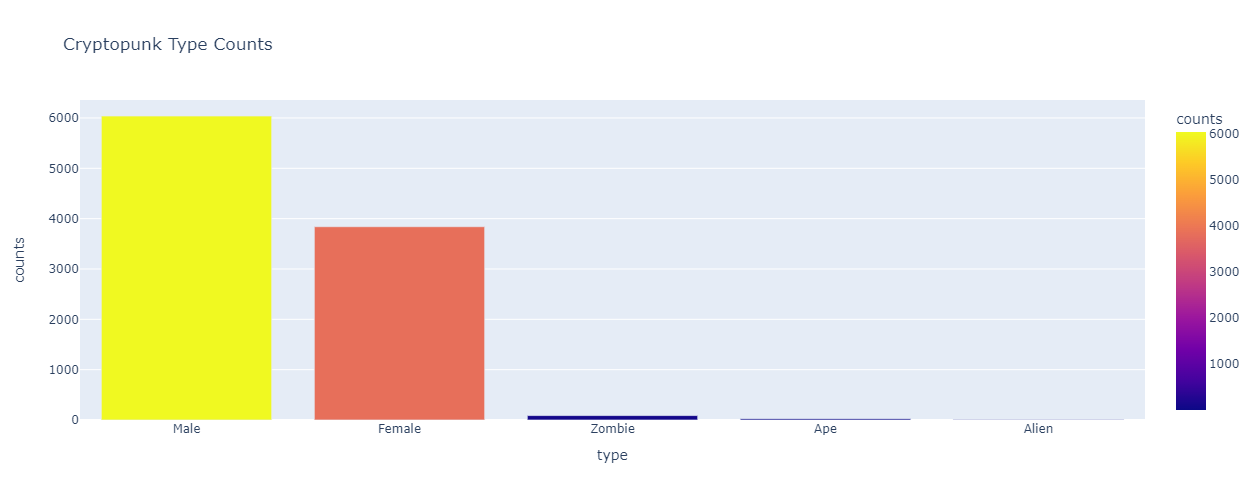

In [236]:
fig = px.bar(tx_attributes_df.drop_duplicates("punk_id")['type'].value_counts().rename_axis('type').reset_index(name='counts'),
             x="type", y="counts", color="counts", title="Cryptopunk Type Counts", width = 1024, height = 500)
fig.show()

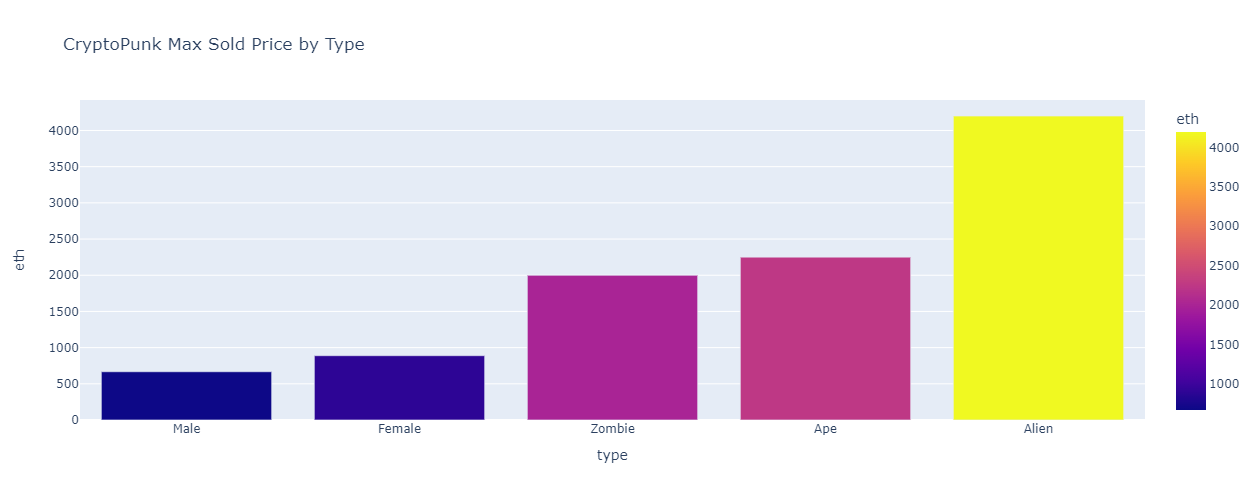

In [237]:
fig = px.bar(tx_attributes_df[tx_attributes_df.txn_type == 'Sold'].groupby("type").agg({"eth": "max"}).sort_values(by="eth").reset_index('type'),
             x="type", y="eth", color="eth", title="CryptoPunk Max Sold Price by Type", width = 1024, height = 500)
fig.show()

We can see there's a very strong inverse relationship between the type counts and the max price for which they're sold.   

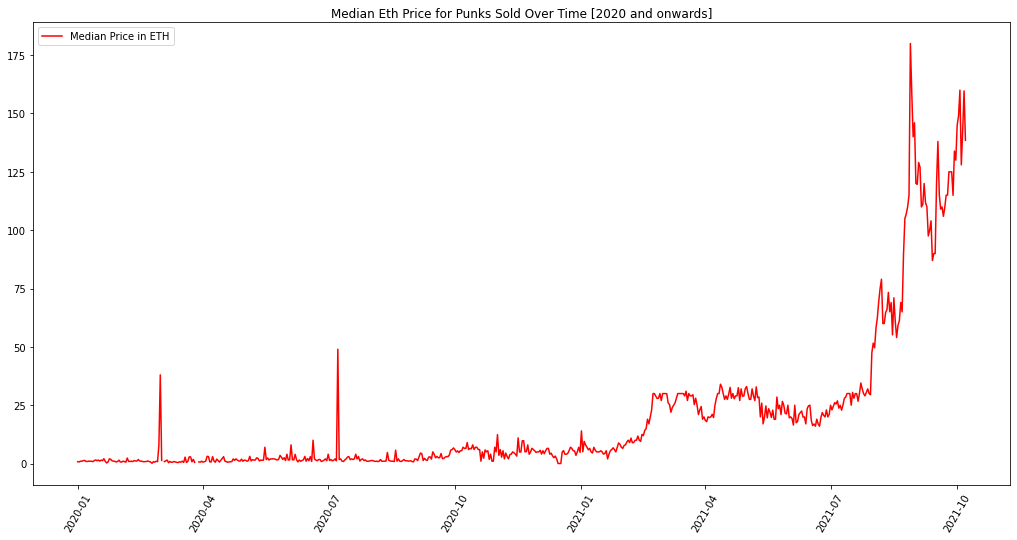

In [238]:
median_price = tx_attributes_df.groupby("date").agg({"eth": ["median"]}).reset_index("date")
median_price_recent = median_price.set_index('date')['2020':]
plt.figure(figsize=(17.5,8.5))
plt.plot(median_price_recent.index, median_price_recent['eth']['median'], label="Median Price in ETH", color='red')
plt.legend()
plt.xticks(rotation=60)
plt.title("Median Eth Price for Punks Sold Over Time [2020 and onwards]")
plt.show()

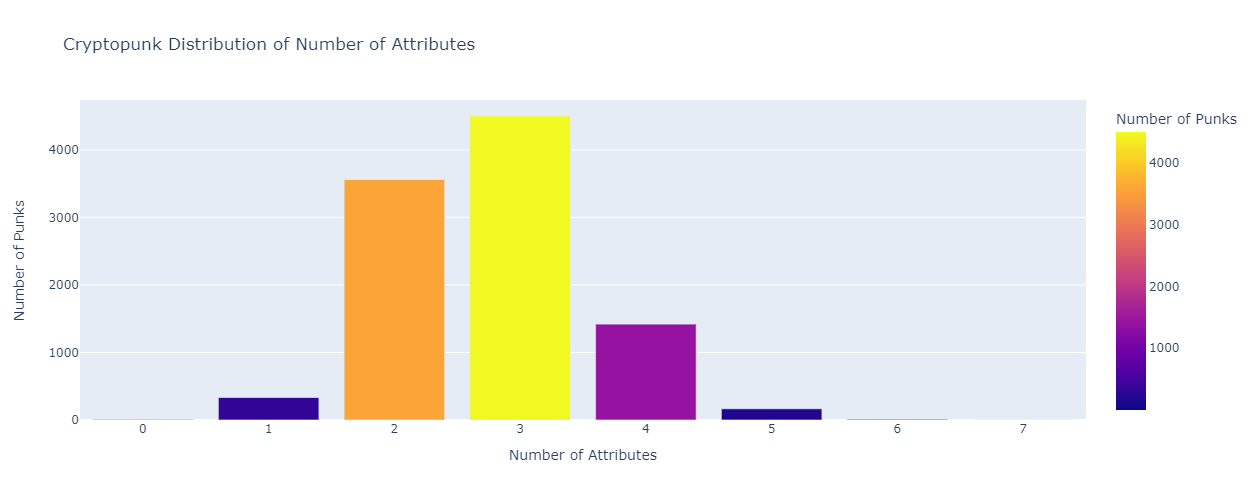

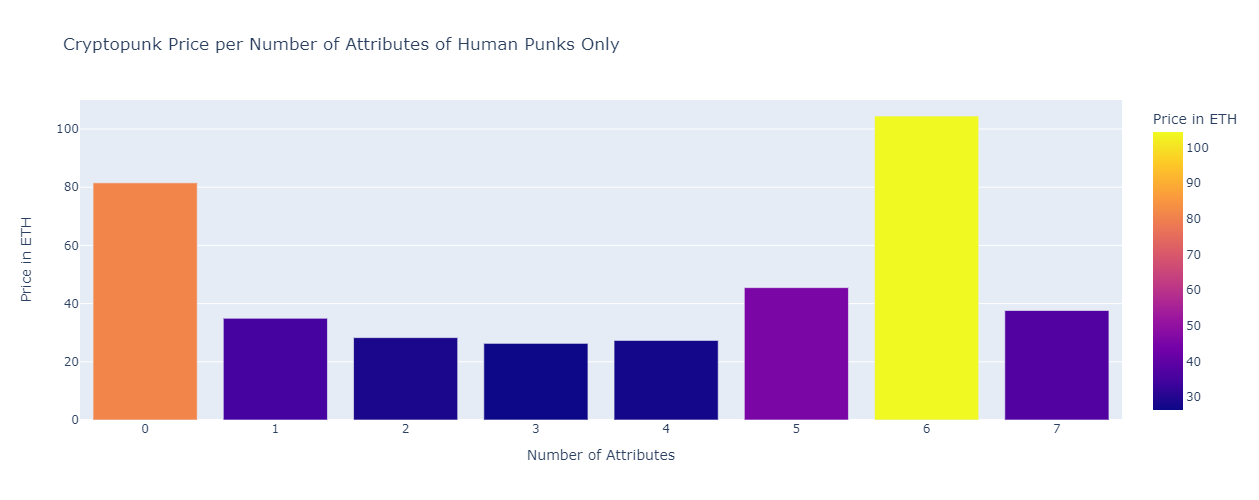

In [239]:
fig = px.bar(tx_attributes_df.drop_duplicates("punk_id")['num_attributes'].value_counts().rename_axis('num_attributes').reset_index(name='counts'),
             x="num_attributes", y="counts", color = 'counts', labels = {'num_attributes': 'Number of Attributes', 'counts':'Number of Punks'},
             title="Cryptopunk Distribution of Number of Attributes", width = 1024, height = 500) # Frequency of number of attributes visualization.
fig.show()

fig = px.bar(tx_attributes_df[(tx_attributes_df.txn_type == "Sold") & ((tx_attributes_df.type == "Female") | (tx_attributes_df.type == "Male"))].groupby("num_attributes").agg({"eth": "mean"}).reset_index("num_attributes"),
             x="num_attributes", y="eth", color="eth", labels = {'num_attributes': 'Number of Attributes', 'eth':'Price in ETH'},
             title="Cryptopunk Price per Number of Attributes of Human Punks Only", width = 1024, height = 500) # Max price based on number of attributes [Human Punks]
fig.show() # For more visualizations, please refer to the dashboard.